In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pytorch-lightning nnAudio
import os
import pandas as pd
import torch
import torchaudio
import torch.nn as nn
from torchmetrics import Accuracy, F1Score
from pytorch_lightning import LightningModule, Trainer
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from nnAudio.features.mel import MelSpectrogram
import torch.nn.functional as F
import torchaudio.transforms as T

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
keyword_folder = "/content/drive/MyDrive/Phonetics_Lab/DATASET/label_1"
non_keyword_folder = "/content/drive/MyDrive/Phonetics_Lab/DATASET/label_0"

In [ ]:
# data labels
def collect_filepaths(folder, label):
    return [{"filepath": os.path.join(folder, fname), "label": label}
            for fname in os.listdir(folder) if fname.endswith(".wav")]

data = collect_filepaths(keyword_folder, label=1) + collect_filepaths(non_keyword_folder, label=0)
df = pd.DataFrame(data)

In [ ]:
# split into train, val, test
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42)

In [ ]:
class KeywordDataset(Dataset):
    def __init__(self, df, target_sr=16000):
        self.df = df.reset_index(drop=True)
        self.target_sr = target_sr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            waveform, sr = torchaudio.load(row["filepath"])
        except Exception:
            print(f"❌ Skipping unreadable file: {row['filepath']}")
            return self.__getitem__((idx + 1) % len(self.df))

        if sr != self.target_sr:
            resampler = torchaudio.transforms.Resample(sr, self.target_sr)
            waveform = resampler(waveform)

        waveform = waveform.squeeze(0)
        if waveform.shape[0] > self.target_sr:
            waveform = waveform[:self.target_sr]
        elif waveform.shape[0] < self.target_sr:
            pad_len = self.target_sr - waveform.shape[0]
            waveform = torch.nn.functional.pad(waveform, (0, pad_len))

        return waveform, int(row["label"])

In [ ]:
# dataloader
def data_processing(batch):
    waveforms = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    padded_waveforms = torch.stack(waveforms, dim=0)
    labels_tensor = torch.tensor(labels)

    return {"waveforms": padded_waveforms, "labels": labels_tensor}
def make_loader(df, batch_size=64, is_train=False):
    dataset = KeywordDataset(df)
    if is_train:
        counts = df['label'].value_counts().to_dict()
        weights = {l: 1.0 / c for l, c in counts.items()}
        sample_weights = [weights[l] for l in df['label']]
        sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler, collate_fn=data_processing)
    else:
        return DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=data_processing)

train_loader = make_loader(train_df, is_train=True)
val_loader = make_loader(val_df)
test_loader = make_loader(test_df)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super().__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        logpt = -F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(logpt)
        return (-((1 - pt) ** self.gamma) * logpt).mean()

class CNNKeywordLightningModel(LightningModule):
    def __init__(self, input_length=16000, n_mels=64, num_classes=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.mel = MelSpectrogram(
            sr=16000, n_fft=480, win_length=None, n_mels=n_mels,
            hop_length=160, norm=1, power=2.0, trainable_mel=False, trainable_STFT=False
        )
        self.db = T.AmplitudeToDB()

        # Deeper CNN
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.classifier = nn.Linear(128, num_classes)
        self.loss_fn = FocalLoss(gamma=2.0)

        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.val_f1 = F1Score(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        spec = self.mel(x)
        spec = self.db(spec)
        spec = spec.unsqueeze(1)  # [B, 1, F, T]
        features = self.cnn(spec)
        return self.classifier(features.view(x.size(0), -1))

    def training_step(self, batch, batch_idx):
        x, y = batch['waveforms'], batch['labels']
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.train_acc(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", self.train_acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['waveforms'], batch['labels']
        logits = self(x)
        loss = self.loss_fn(logits, y)
        self.val_acc(logits, y)
        self.val_f1(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", self.val_acc, prog_bar=True)
        self.log("val_f1", self.val_f1, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch['waveforms'], batch['labels']
        logits = self(x)
        self.test_acc(logits, y)
        self.test_f1(logits, y)
        self.log("test_acc", self.test_acc, prog_bar=True)
        self.log("test_f1", self.test_f1, prog_bar=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)


In [ ]:
# learning
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

logger = CSVLogger("lightning_logs", name="kws")
checkpoint = ModelCheckpoint(
    monitor="val_f1", mode="max",
    filename="best-model-{epoch:02d}-{val_f1:.2f}",
    save_top_k=1
)

model = CNNKeywordLightningModel()

trainer = Trainer(
    max_epochs=10,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    logger=logger,
    callbacks=[checkpoint]
)

trainer.fit(model, train_loader, val_loader)
trainer.save_checkpoint("/content/drive/MyDrive/Phonetics_Lab/models/cnn_model_new.ckpt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


STFT kernels created, time used = 0.0178 seconds
STFT filter created, time used = 0.0013 seconds
Mel filter created, time used = 0.0014 seconds


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | mel        | MelSpectrogram     | 0      | train
1 | db         | AmplitudeToDB      | 0      | train
2 | cnn        | Sequential         | 97.6 K | train
3 | classifier | Linear             | 258    | train
4 | loss_fn    | FocalLoss          | 0      | train
5 | train_acc  | MulticlassAccuracy | 0      | train
6 | val_acc    | MulticlassAccuracy | 0      | train
7 | val_f1     | MulticlassF1Score  | 0      | train
8 | test_acc   | MulticlassAccuracy | 0      | train
9 | test_f1    | MulticlassF1Score  | 0      | train
----------------------------------------------------------
97.9 K    Trainable params
0         Non-trainable params
97.9 K    Total params
0.392     Total estimated model params size (MB)
27        Modules in train mode
0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_20c531f4-9e6f-4cf0-bb20-70a672339d84_chunk7.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_037bd8e9-2731-4494-8bb7-b6b00c2f0892_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/типа_f41676ac-bdf5-449d-81f1-faa7c6ba88b4_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/все_dfd41231-52fd-4da9-bd14-5f108eabaf21_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/ты_84cbae83-dece-4dbd-9c2e-532acbdd1f0a_chunk6.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_20c531f4-9e6f-4cf0-bb20-70a672339d84_chunk7.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/l

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/до_0ccc2e18-ae07-4ce5-a74f-1c8b4a4b9e03_chunk16.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_33a4cffa-1840-463c-8e2e-c7ef1a11251f_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/типа_f41676ac-bdf5-449d-81f1-faa7c6ba88b4_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/х_f87d73d0-16c6-4e51-86db-d2daea7b7bba_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATA

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/видео_38412558-9f77-4d5a-a74a-41bbc60f5c81_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/там_44e51e95-3a54-4d1f-b903-f2a271609b74_chunk10.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/х_f87d73d0-16c6-4e51-86db-d2daea7b7bba_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/видео_38412558-9f77-4d5a-a74a-41bbc60f5c81_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/будут_36ce9aa0-2113-4641-a1c9-f163ce0659b8_chunk15.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/что_03e0ba08-5b42-4b24-9efd-00149087d712_chunk2.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/типа_f41676ac-bdf5-449d-81f1-faa7c6ba88b4_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/такие_e0fa12fe-c8e6-4e89-923d-1ed437dfe80c_chunk19.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/ты_84cbae83-dece-4dbd-9c2e-532acbdd1f0a_chunk6.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_33a4cffa-1840-463c-8e2e-c7ef1a11251f_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/наверное_29d78e1c-ec77-416b-9925-d5c884e695cb_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/будут_36ce9aa0-2113-4641-a1c9-f163ce0659b8_chunk15.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_20c531f4-9e6f-4cf0-bb20-70a672339d84_chunk7.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_037bd8e9-2731-4494-8bb7-b6b00c2f0892_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_037bd8e9-2731-4494-8bb7-b6b00c2f0892_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/ты_84cbae83-dece-4dbd-9c2e-532acbdd1f0a_chunk6.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/там_44e51e95-3a54-4d1f-b903-f2a271609b74_chunk10.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/Если_4ab46734-2112-4d66-8862-ae32293bef92_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/до_0ccc2e18-ae07-4ce5-a74f-1c8b4a4b9e03_chunk16.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/все_dfd41231-52fd-4da9-bd14-5f108eabaf21_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_6a14483b-d557-44a0-a5ad-e519b6d1661f_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/типа_f41676ac-bdf5-449d-81f1-faa7c6ba88b4_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/видео_38412558-9f77-4d5a-a74a-41bbc60f5c81_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/там_44e51e95-3a54-4d1f-b903-f2a271609b74_chunk10.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/Если_4ab46734-2112-4d66-8862-ae32293bef92_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_78853007-6fa6-4089-abc2-56614bd8c248_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/D

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/все_dfd41231-52fd-4da9-bd14-5f108eabaf21_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_78853007-6fa6-4089-abc2-56614bd8c248_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_67800255-cda0-410c-ad1b-b1a4e26ae394_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_6a14483b-d557-44a0-a5ad-e519b6d1661f_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/наверное_29d78e1c-ec77-416b-9925-d5c884e695cb_chunk1.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_78853007-6fa6-4089-abc2-56614bd8c248_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATA

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/там_44e51e95-3a54-4d1f-b903-f2a271609b74_chunk10.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/с_f6efc680-8c36-4d92-a9f8-6237cf7935c8_chunk0.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/ты_84cbae83-dece-4dbd-9c2e-532acbdd1f0a_chunk6.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_6a14483b-d557-44a0-a5ad-e519b6d1661f_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/до_0ccc2e18-ae07-4ce5-a74f-1c8b4a4b9e03_chunk16.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/Если_4ab46734-2112-4d66-8862-ae32293bef92_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/х_f87d73d0-16c6-4e51-86db-d2daea7b7bba_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/ты_84cbae83-dece-4dbd-9c2e-532acbdd1f0a_chunk6.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/х_f87d73d0-16c6-4e51-86db-d2daea7b7bba_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/чтобы_1bf46ace-81fb-4b0f-b3c0-bfe3c6303431_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_20c531f4-9e6f-4cf0-bb20-70a672339d84_chunk7.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/Если_4ab46734-2112-4d66-8862-ae32293bef92_chunk5.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_6a14483b-d557-44a0-a5ad-e519b6d1661f_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/до_0ccc2e18-ae07-4ce5-a74f-1c8b4a4b9e03_chunk16.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASE

Validation: |          | 0/? [00:00<?, ?it/s]

❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/вот_33a4cffa-1840-463c-8e2e-c7ef1a11251f_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_20c531f4-9e6f-4cf0-bb20-70a672339d84_chunk7.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/все_dfd41231-52fd-4da9-bd14-5f108eabaf21_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_20c531f4-9e6f-4cf0-bb20-70a672339d84_chunk7.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/видео_38412558-9f77-4d5a-a74a-41bbc60f5c81_chunk3.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/у_78853007-6fa6-4089-abc2-56614bd8c248_chunk4.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATASET/label_0/чтобы_1bf46ace-81fb-4b0f-b3c0-bfe3c6303431_chunk12.wav
❌ Skipping unreadable file: /content/drive/MyDrive/Phonetics_Lab/DATAS

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [ ]:
# loading the best model
best_model = CNNKeywordLightningModel.load_from_checkpoint(checkpoint.best_model_path)

trainer.test(best_model, dataloaders=test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


STFT kernels created, time used = 0.0083 seconds
STFT filter created, time used = 0.0012 seconds
Mel filter created, time used = 0.0013 seconds


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7457286715507507     │
│          test_f1          │    0.7457286715507507     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.7457286715507507, 'test_f1': 0.7457286715507507}]

✅ Test Accuracy: 0.7457
✅ Test F1 Score: 0.7546
🧩 Confusion Matrix:
[[353 144]
 [109 389]]


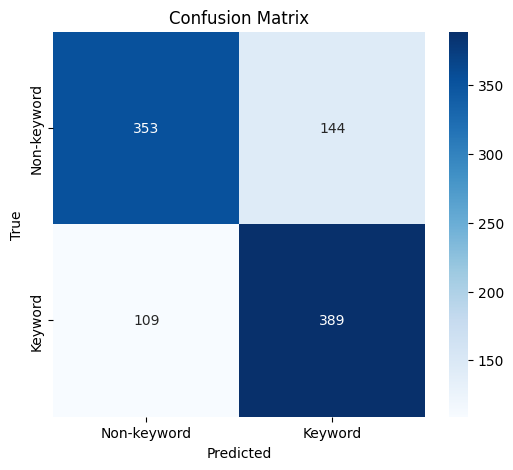

In [ ]:
# evaluation
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def manual_test_evaluation(model, dataloader, device='cuda'):
    model.to(device)
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in dataloader:
            x = batch['waveforms'].to(device)
            y = batch['labels'].to(device)
            logits = model(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"✅ Test Accuracy: {acc:.4f}")
    print(f"✅ Test F1 Score: {f1:.4f}")
    print("🧩 Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-keyword', 'Keyword'],
                yticklabels=['Non-keyword', 'Keyword'])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


manual_test_evaluation(best_model, test_loader)